In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-1/mnist.npz


In [2]:
import numpy as np
import keras
import tensorflow as tf
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as pyplot


# ***MNET-read***

In [3]:
path1 = "/kaggle/input/mnist-1/mnist.npz" 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path1)
y_train= to_categorical(y_train)
y_val = to_categorical(y_test)
print(np.shape(x_train))
print(np.shape(x_test))

(60000, 28, 28)
(10000, 28, 28)


In [4]:
train_x = x_train.reshape(60000, 28,28,1) / 255
val_x = x_test.reshape(10000,28, 28, 1) / 255


# ***ENCODER***

In [5]:
#encoder
filters=(32, 64)
chanDim = -1
latentDim=16
# define the input to the encoder
inputs = Input(shape=(28,28,1))
x = inputs
# loop over the number of filters
for f in filters:
	# apply a CONV => RELU => BN operation
	x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = BatchNormalization(axis=chanDim)(x)
# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)
# build the encoder model
encoder = Model(inputs, latent, name="encoder")

In [6]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256 

# ***DECODER***

In [7]:
#decoder
# output of the encoder as its inputs
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

for f in filters[::-1]:
	# apply a CONV_TRANSPOSE => RELU => BN operation
	x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = BatchNormalization(axis=chanDim)(x)

In [8]:
# apply a single CONV_TRANSPOSE layer used to recover the
# original depth of the image
x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)
# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")
# our autoencoder is the encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        1846

In [10]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69392     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


In [11]:
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())


In [12]:
#x= train_x(what we input), y= train_x(what is desired output) same for validation 
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10, verbose=1, validation_data=(val_x, val_x))


Epoch 1/10
59/59 [==============================] - 78s 1s/step - loss: 0.1455 - val_loss: 0.1042
Epoch 2/10
59/59 [==============================] - 76s 1s/step - loss: 0.0470 - val_loss: 0.0930
Epoch 3/10
59/59 [==============================] - 75s 1s/step - loss: 0.0232 - val_loss: 0.0931
Epoch 4/10
59/59 [==============================] - 75s 1s/step - loss: 0.0183 - val_loss: 0.0878
Epoch 5/10
59/59 [==============================] - 76s 1s/step - loss: 0.0160 - val_loss: 0.0830
Epoch 6/10
59/59 [==============================] - 75s 1s/step - loss: 0.0144 - val_loss: 0.0739
Epoch 7/10
59/59 [==============================] - 75s 1s/step - loss: 0.0133 - val_loss: 0.0587
Epoch 8/10
59/59 [==============================] - 75s 1s/step - loss: 0.0125 - val_loss: 0.0413
Epoch 9/10
59/59 [==============================] - 76s 1s/step - loss: 0.0118 - val_loss: 0.0277
Epoch 10/10
59/59 [==============================] - 76s 1s/step - loss: 0.0114 - val_loss: 0.0164


#  ***RESULTS***

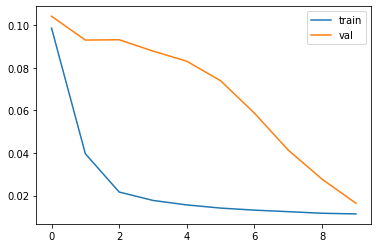

In [13]:
pyplot.plot(trained_model.history['loss'], label='train')
pyplot.plot(trained_model.history['val_loss'], label='val')
pyplot.legend()
pyplot.savefig('plot.png')
pyplot.show()

In [14]:
decoded_output = autoencoder.predict(train_x)*255 
np.shape(decoded_output)
decoded_output=decoded_output.reshape(60000, 28, 28)
np.shape(decoded_output)

(60000, 28, 28)

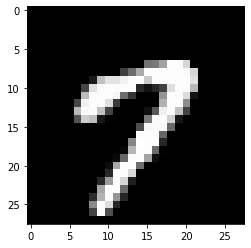

In [15]:
pyplot.imshow(x_train[15,:,:], cmap=pyplot.get_cmap('gray'))


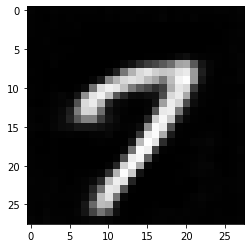

In [16]:
pyplot.imshow(decoded_output[15,:,:], cmap=pyplot.get_cmap('gray'))

# ***CLASSIFICATION WITH AUTOENCODER***

In [17]:
encoder.save('encoder.h5')

In [18]:
from tensorflow.keras.models import load_model
encoder= load_model('encoder.h5')
x= encoder.output
preds=Dense(10,activation='softmax')(x)
model=Model(inputs=encoder.input,outputs=preds)

In [19]:
for layer in model.layers[:8]:
    layer.trainable=False
for layer in model.layers[8:]:
    layer.trainable=True

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256   

In [21]:
train_datagen=ImageDataGenerator(rescale=1) #included in our dependencies
validation_datagen = ImageDataGenerator(rescale=1)


In [22]:
train_gen = train_datagen.flow(
        train_x,y_train, 
        batch_size=30
)


val_gen = validation_datagen.flow(
        val_x,y_val)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history_class = model.fit(
       train_gen,
       epochs=20,
       validation_data=val_gen,
       verbose=1
    )


Epoch 1/20
2000/2000 [==============================] - 11s 5ms/step - loss: 1.3494 - accuracy: 0.7131 - val_loss: 0.2118 - val_accuracy: 0.9380
Epoch 2/20
2000/2000 [==============================] - 11s 6ms/step - loss: 0.2020 - accuracy: 0.9415 - val_loss: 0.1448 - val_accuracy: 0.9607
Epoch 3/20
2000/2000 [==============================] - 11s 5ms/step - loss: 0.1526 - accuracy: 0.9557 - val_loss: 0.1161 - val_accuracy: 0.9681
Epoch 4/20
2000/2000 [==============================] - 10s 5ms/step - loss: 0.1222 - accuracy: 0.9664 - val_loss: 0.0988 - val_accuracy: 0.9727
Epoch 5/20
2000/2000 [==============================] - 11s 5ms/step - loss: 0.1026 - accuracy: 0.9707 - val_loss: 0.0911 - val_accuracy: 0.9737
Epoch 6/20
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0922 - accuracy: 0.9743 - val_loss: 0.0852 - val_accuracy: 0.9774
Epoch 7/20
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0788 - accuracy: 0.9774 - val_loss: 0.0792 - val_ac

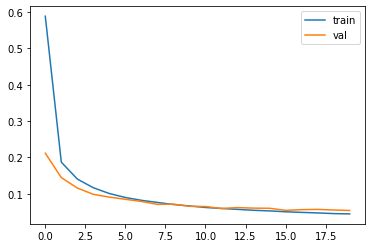

In [25]:
pyplot.plot(history_class.history['loss'], label='train')
pyplot.plot(history_class.history['val_loss'], label='val')
pyplot.legend()
pyplot.savefig('plot_1.png')
pyplot.show()

Actual label: 5
Predicted label: [5]


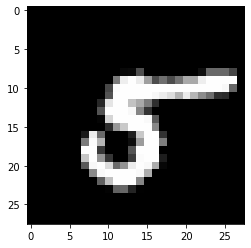

In [27]:
i=9998
pyplot.imshow(x_test[i,:,:], cmap=pyplot.get_cmap('gray'))
print('Actual label:',y_test[i])

#predicted label
output = model.predict(val_x)
maxElement = np.amax(output[i,:])
result = np.where(output[i,:]== maxElement)
print('Predicted label:', result[0])
